## Import library

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing

## Import dataset

In [273]:
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

## Split train, test

In [274]:
# EUR - VND
  # case 1. 7:3
train_eur_1 = eur[:int(0.7*len(eur))]
test_eur_1 = eur[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2 = eur[:int(0.8*len(eur))]
test_eur_2 = eur[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3 = eur[:int(0.9*len(eur))]
test_eur_3 = eur[int(0.9*len(eur)):]

# GBP - VND
  # case 1. 7:3
train_gbp_1 = gbp[:int(0.7*len(gbp))]
test_gbp_1 = gbp[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2 = gbp[:int(0.8*len(gbp))]
test_gbp_2 = gbp[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3 = gbp[:int(0.9*len(gbp))]
test_gbp_3 = gbp[int(0.9*len(gbp)):]

# JPY - VND
  # case 1. 7:3
train_jpy_1 = jpy[:int(0.7*len(jpy))]
test_jpy_1 = jpy[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2 = jpy[:int(0.8*len(jpy))]
test_jpy_2 = jpy[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3 = jpy[:int(0.9*len(jpy))]
test_jpy_3 = jpy[int(0.9*len(jpy)):]

## Evaluate model

In [275]:
def accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

## ETS (Exponential Smoothing)

#### Build model

In [276]:
def build_model(data):
  model = ExponentialSmoothing(data, trend=None, seasonal=None).fit()
  return model

#### Forecast 30,60,90 days

In [277]:
def forecast_days(train, predicted_test):
    train_predicted = np.concatenate([train, predicted_test])
    
    # Forecast next 30 days
    model_30 = build_model(train_predicted)
    forecast30 = model_30.forecast(steps=30)
    train_predicted_30 = np.concatenate([train_predicted, forecast30])
    
    # Forecast the next 60 days
    model_60 = build_model(train_predicted_30)
    forecast60 = model_60.forecast(steps=30)
    train_predicted_60 = np.concatenate([train_predicted_30, forecast60])
    
    # Forecast the next 90 days
    model_90 = build_model(train_predicted_60)
    forecast90 = model_90.forecast(steps=30)
    
    return forecast30, forecast60, forecast90

#### Predict test data

In [278]:
# Define function predict next 30, 60, 90 days
def predict_data_ETS(model, train, test):
  pre_test = model.predict(start=len(train), end=len(train) + len(test) - 1)
  forecast30, forecast60, forecast90 = forecast_days(train, pre_test)
  return pre_test, forecast30, forecast60, forecast90

#### Visualize data

In [279]:
def visualise_ETS_model(train, test, pre_test, f30, f60, f90):
    plt.figure(figsize=(12, 6))

    start_date = pd.to_datetime('3/1/2019')
    end_date = pd.to_datetime('6/1/2024')
    start_date_fc = pd.to_datetime('6/2/2024')

    index = pd.date_range(start=start_date, end=end_date, freq='D')
    forecast_index = pd.date_range(start=start_date_fc, periods=90, freq='D')

    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    plt.xticks(x_ticks, unique_years)    

    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    
    f30_index = forecast_index[:30]
    f60_index = forecast_index[30:60]
    f90_index = forecast_index[60:]

    plt.plot(train_index, train, label='Train', color='blue')
    plt.plot(test_index, test, label='Actual Test', color='orange')
    plt.plot(test_index, pre_test, label='Prediction Test', color='green')

    plt.plot(f30_index, f30, label='Forecast next 30 days', color='red')
    plt.plot(f60_index, f60, label='Forecast next 60 days', color='purple')
    plt.plot(f90_index, f90, label='Forecast next 90 days', color='pink')
    
    plt.title('ETS Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend()
    
    plt.show()

In [280]:
model_eur_1 = build_model(train_eur_1)
model_eur_2 = build_model(train_eur_2)
model_eur_3 = build_model(train_eur_3)

model_jpy_1 = build_model(train_jpy_1)
model_jpy_2 = build_model(train_jpy_2)
model_jpy_3 = build_model(train_jpy_3)

model_gbp_1 = build_model(train_gbp_1)
model_gbp_2 = build_model(train_gbp_2)
model_gbp_3 = build_model(train_gbp_3)

#### EUR_VND

* Case 7:3

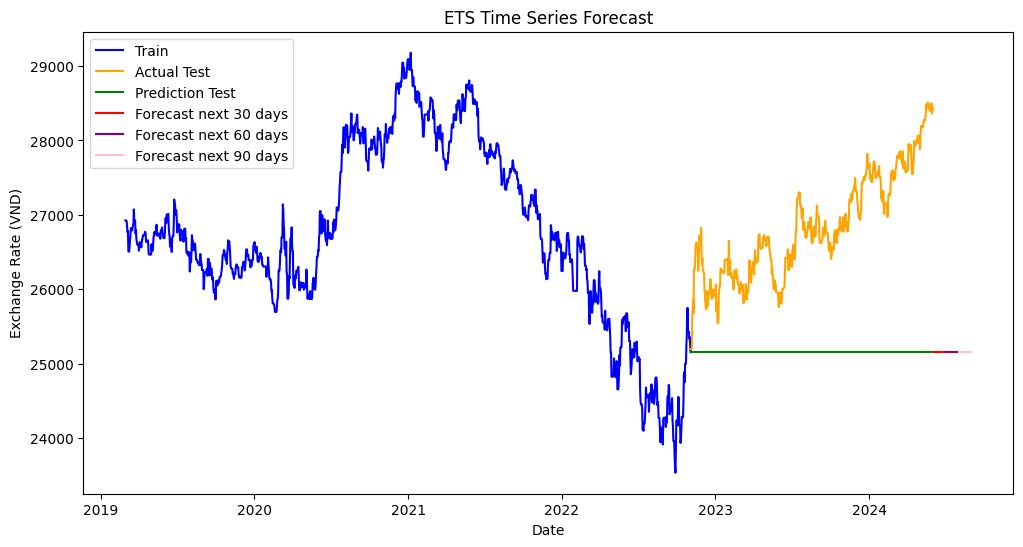

Model accuracy (EUR - 7:3)
RMSE = 1830.3799993429814
MAPE = 6.221811248659162
MAE = 1687.4070470113174


In [281]:
predict_test_eur_1, forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90 = predict_data_ETS(model_eur_1, train_eur_1, test_eur_1)
visualise_ETS_model(train_eur_1,test_eur_1,predict_test_eur_1,forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90)

print('Model accuracy (EUR - 7:3)')
accuracy(predict_test_eur_1, test_eur_1)

* Case 8:2

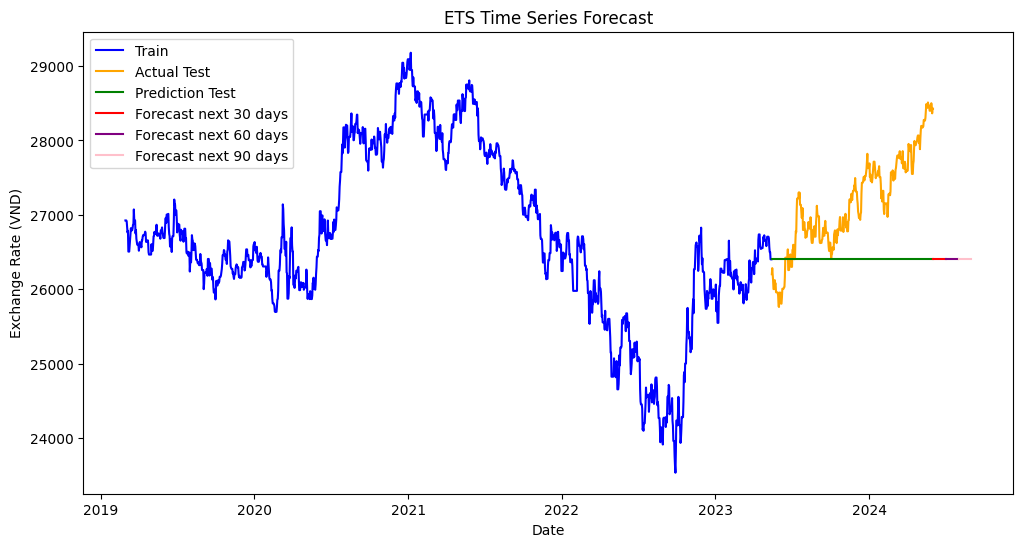

Model accuracy (EUR - 8:2)
RMSE = 987.5111120928113
MAPE = 2.9982237857152607
MAE = 825.4913557421904


In [282]:
predict_test_eur_2, forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90 = predict_data_ETS(model_eur_2, train_eur_2, test_eur_2)
visualise_ETS_model(train_eur_2,test_eur_2,predict_test_eur_2,forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90)

print('Model accuracy (EUR - 8:2)')
accuracy(predict_test_eur_2, test_eur_2)

* Case 9:1

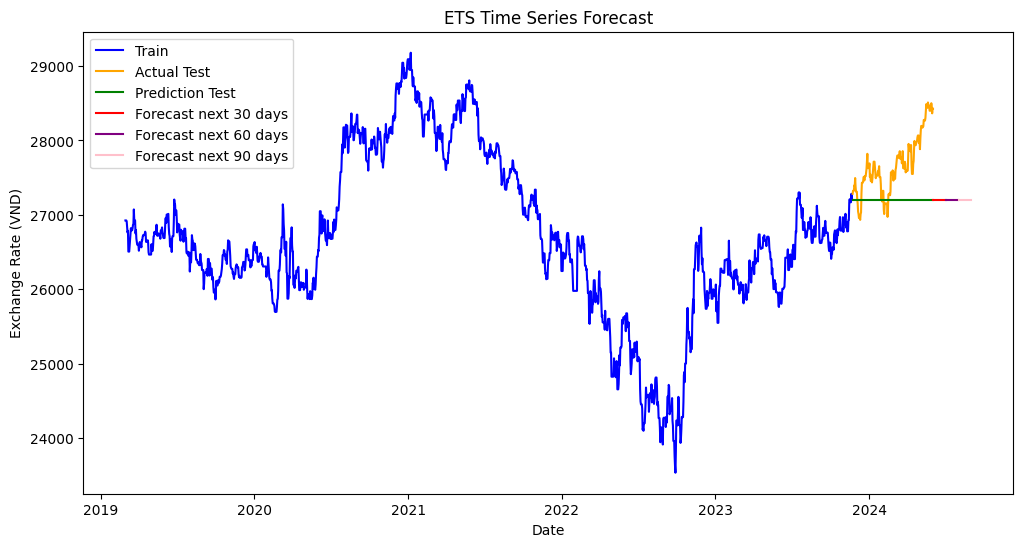

Model accuracy (EUR - 9:1)
RMSE = 609.9227991546263
MAPE = 1.7888453471610097
MAE = 499.5997486811473


In [283]:
predict_test_eur_3, forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90 = predict_data_ETS(model_eur_3, train_eur_3, test_eur_3)
visualise_ETS_model(train_eur_3,test_eur_3,predict_test_eur_3,forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90)

print('Model accuracy (EUR - 9:1)')
accuracy(predict_test_eur_3, test_eur_3)

#### JPY_VND

* Case 7:3

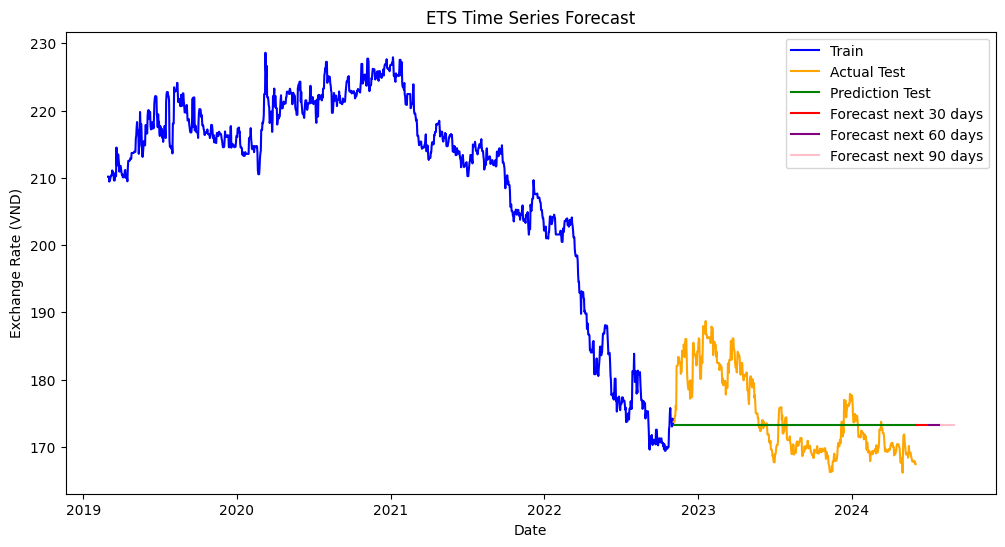

Model accuracy (JPY - 7:3)
RMSE = 6.192424203571645
MAPE = 2.862576357137842
MAE = 5.083123401121189


In [284]:
predict_test_jpy_1, forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90 = predict_data_ETS(model_jpy_1, train_jpy_1, test_jpy_1)
visualise_ETS_model(train_jpy_1,test_jpy_1,predict_test_jpy_1,forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90)

print('Model accuracy (JPY - 7:3)')
accuracy(predict_test_jpy_1, test_jpy_1)

* Case 8:2

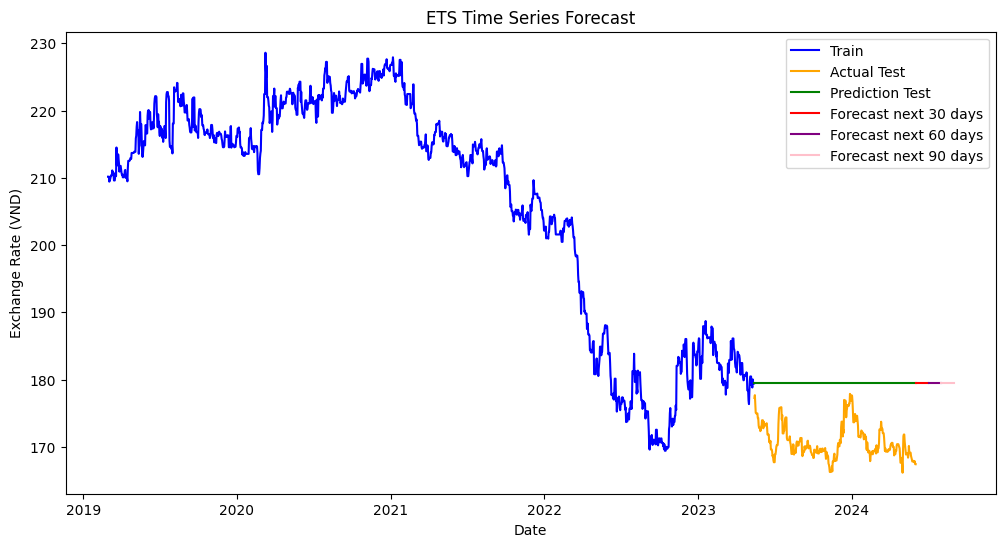

Model accuracy (JPY - 8:2)
RMSE = 8.94079363804543
MAPE = 5.044852241210551
MAE = 8.580770880858994


In [285]:
predict_test_jpy_2, forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90 = predict_data_ETS(model_jpy_2, train_jpy_2, test_jpy_2)
visualise_ETS_model(train_jpy_2,test_jpy_2,predict_test_jpy_2,forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90)

print('Model accuracy (JPY - 8:2)')
accuracy(predict_test_jpy_2, test_jpy_2)

* Case 9:1

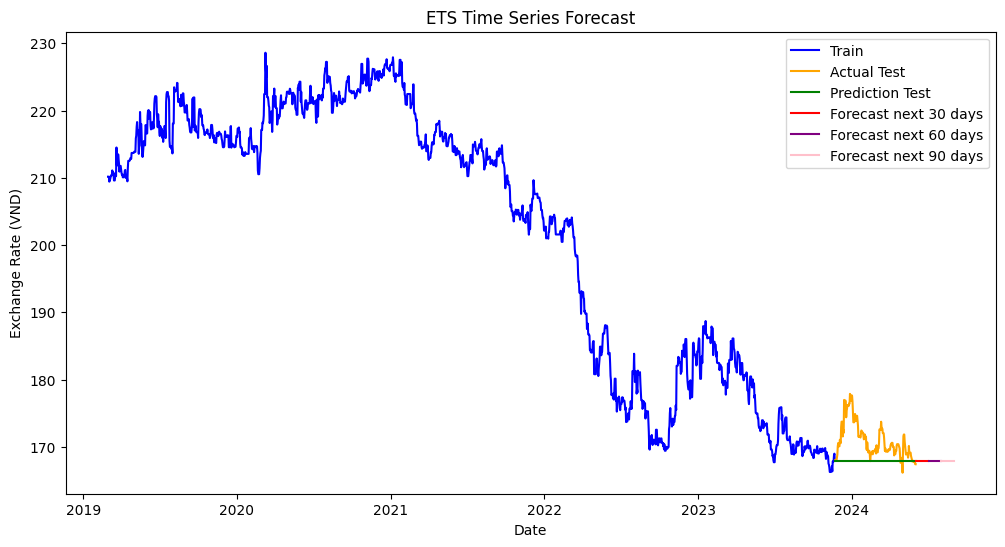

Model accuracy (JPY - 9:1)
RMSE = 4.032431926917446
MAPE = 1.7960604072027362
MAE = 3.1093028216415703


In [286]:
predict_test_jpy_3, forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90 = predict_data_ETS(model_jpy_3, train_jpy_3, test_jpy_3)
visualise_ETS_model(train_jpy_3,test_jpy_3,predict_test_jpy_3,forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90)

print('Model accuracy (JPY - 9:1)')
accuracy(predict_test_jpy_3, test_jpy_3)

#### GBP_VND

* Case 7:3

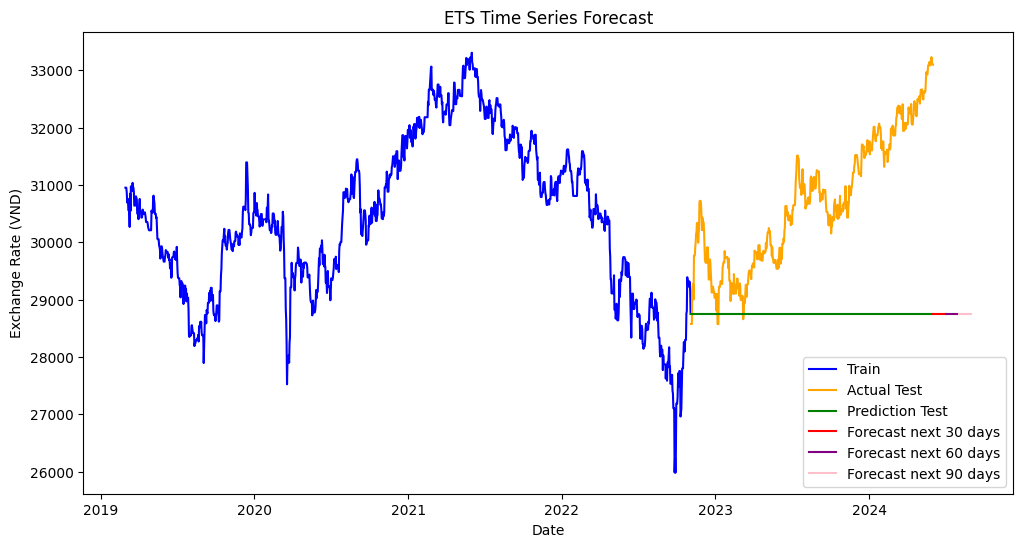

Model accuracy (GBP - 7:3)
RMSE = 2262.8802902334805
MAPE = 6.290236130163447
MAE = 1970.0916489381468


In [287]:
predict_test_gbp_1, forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90 = predict_data_ETS(model_gbp_1, train_gbp_1, test_gbp_1)
visualise_ETS_model(train_gbp_1,test_gbp_1,predict_test_gbp_1,forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90)

print('Model accuracy (GBP - 7:3)')
accuracy(predict_test_gbp_1, test_gbp_1)

* Case 8:2

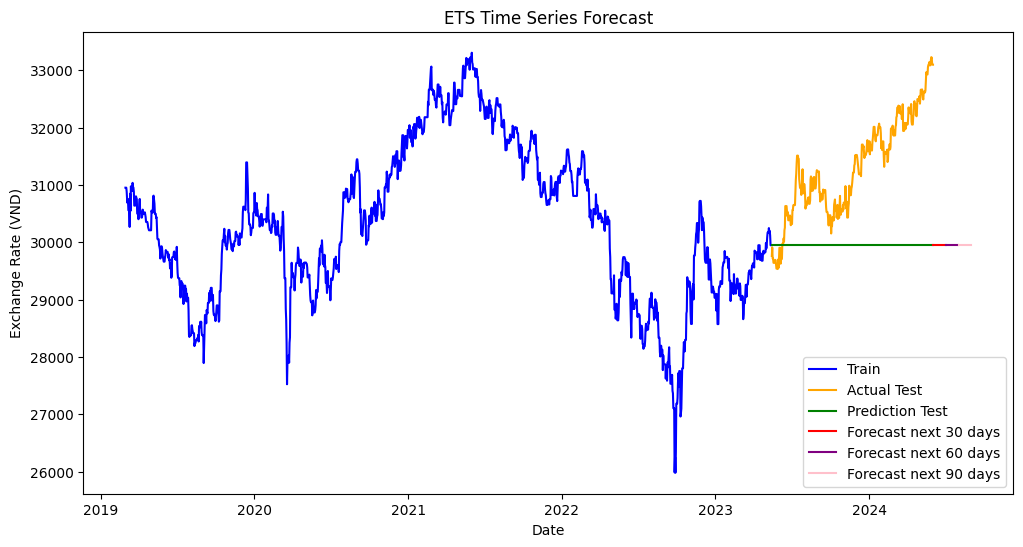

Model accuracy (GBP - 8:2)
RMSE = 1610.1136979596072
MAPE = 4.373431741193687
MAE = 1390.1248532350248


In [288]:
predict_test_gbp_2, forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90 = predict_data_ETS(model_gbp_2, train_gbp_2, test_gbp_2)
visualise_ETS_model(train_gbp_2,test_gbp_2,predict_test_gbp_2,forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90)

print('Model accuracy (GBP - 8:2)')
accuracy(predict_test_gbp_2, test_gbp_2)

* Case 9:1

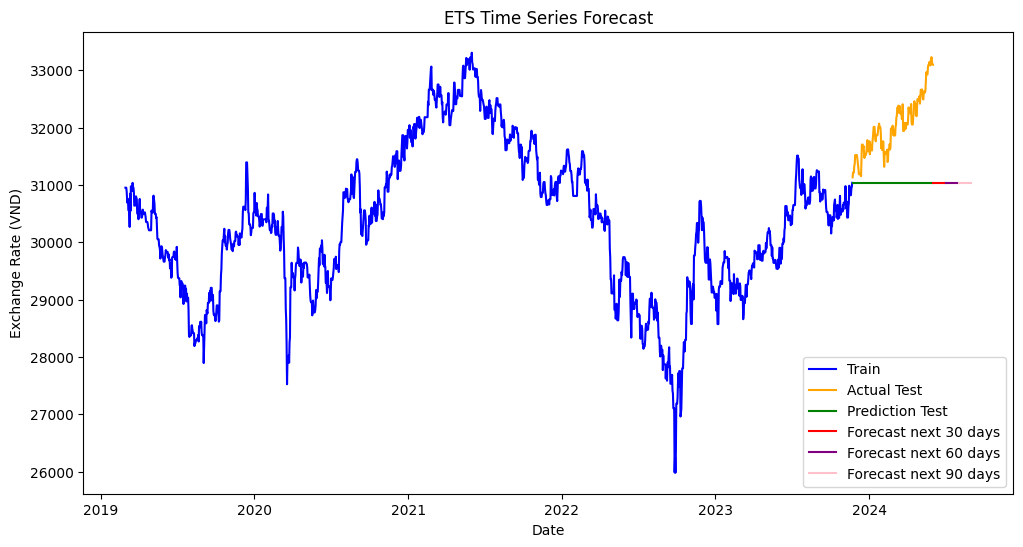

Model accuracy (GBP - 9:1)
RMSE = 1113.7055747955983
MAPE = 3.074859645009123
MAE = 992.4323821496206


In [289]:
predict_test_gbp_3, forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90 = predict_data_ETS(model_gbp_3, train_gbp_3, test_gbp_3)
visualise_ETS_model(train_gbp_3,test_gbp_3,predict_test_gbp_3,forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90)

print('Model accuracy (GBP - 9:1)')
accuracy(predict_test_gbp_3, test_gbp_3)